**Задача по прогнозированию ошибки модели оценки вероятности дефолта (MPP)**

Мы долго работали и построили модель оценки вероятности дефолта (PD модель). Все работает прекрасно, но нужно контролировать качество этой базовой модели и оценивать ошибку, индуцированную базовой моделью, поэтому нам нужно разработать модель прогнозирования ошибки (MPP). Ошибка в нашем случае - это разница между флагом flg_90_12_add, представляющим собой реализованное событие (0 - не дефолт, 1 - дефолт) и значением PD, представляющим собой оценку от нашей базовой модели.

Таким образом, Вам необходимо обучить модель прогнозирования ошибки с использованием двух датасетов и предсказать метрику |PD-flg_90_12_add| для тестовой выборки - тысячи последних экспериментов (incident), где значения PD и flg_90_12_add равны NaN.

Исходные файлы:

* data.csv — данные об экспериментах (incident), включая большое количество признаков и флаг flg_90_12_add, представляющий собой реализованное событие (0 - не дефолт, 1 - дефолт)
* model.csv — результаты прогнозирования дефолта (PD), полученные в нашей разработанной модели
* sample_submission.csv — пример файла, который необходимо отправить

Результаты решения прикрепите в CSV формате. Файл должен содержать только прогнозные значения |PD-flg_90_12_add| для тестовой выборки - тысячи последних экспериментов (incident), где значения PD и flg_90_12_add равны NaN, в одном столбце без заголовка. В качестве оценки решения будет использоваться характеристика MAE.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from catboost import CatBoostRegressor

In [2]:
import logging
import os
import time
import requests
logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s', level=logging.INFO)

#from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
#from lightautoml.tasks import Task

# Данные

In [3]:
data = pd.read_csv('data.csv')
model = pd.read_csv('model.csv')

In [4]:
sample_submission = pd.read_csv('sample_submission.csv', header=None)

In [5]:
data.head()

,incident,flg_90_12_add,APPLICATION_MONTH,Category_Feature_0,Category_Feature_1,Category_Feature_2,Category_Feature_3,Category_Feature_4,Category_Feature_5,Category_Feature_6,...,Feature_1878,Feature_1879,Feature_1880,Feature_1881,Feature_1882,Feature_1883,Feature_1884,Feature_1885,Feature_1886,Feature_1887
0,14511110,0.0,2018-10,6.0,2,25,2.0,0.0,3,1,...,NaN,NaN,NaN,NaN,NaN,0,0,0,1,20184
1,15018800,0.0,2018-12,1.0,2,49,4.0,0.0,3,1,...,0.14384,0.259385,0.547065,0.28768,0.28768,0,1,1,1,20184
2,14499737,0.0,2018-10,6.0,2,24,1.0,0.0,3,0,...,NaN,0.420321,0.242687,NaN,NaN,0,1,0,1,20184
3,14953427,0.0,2018-12,4.0,2,26,1.0,0.0,3,1,...,NaN,NaN,NaN,NaN,NaN,0,1,1,1,20184
4,14744453,0.0,2018-11,6.0,2,30,4.0,2.0,3,1,...,NaN,0.045863,NaN,NaN,NaN,0,1,0,1,20184


In [6]:
model.head()

,incident,PD
0,14511110,0.022191
1,15018800,0.019972
2,14499737,0.043884
3,14953427,0.013412
4,14744453,0.033354


Проверим, является ли incident внешним ключом

In [7]:
print('Уникальных индексов incident в data:  ', data['incident'].nunique())
print('Уникальных индексов incident в model: ', model['incident'].nunique())
print('Индексы incident совпадают?  --  ', np.array_equal(data['incident'], model['incident']))

Уникальных индексов incident в data:   82617
Уникальных индексов incident в model:  82617
Индексы incident совпадают?  --   True


Объеденим эти датасеты по incident

In [8]:
df = pd.merge(data, model, on='incident')
df.head()

,incident,flg_90_12_add,APPLICATION_MONTH,Category_Feature_0,Category_Feature_1,Category_Feature_2,Category_Feature_3,Category_Feature_4,Category_Feature_5,Category_Feature_6,...,Feature_1879,Feature_1880,Feature_1881,Feature_1882,Feature_1883,Feature_1884,Feature_1885,Feature_1886,Feature_1887,PD
0,14511110,0.0,2018-10,6.0,2,25,2.0,0.0,3,1,...,NaN,NaN,NaN,NaN,0,0,0,1,20184,0.022191
1,15018800,0.0,2018-12,1.0,2,49,4.0,0.0,3,1,...,0.259385,0.547065,0.28768,0.28768,0,1,1,1,20184,0.019972
2,14499737,0.0,2018-10,6.0,2,24,1.0,0.0,3,0,...,0.420321,0.242687,NaN,NaN,0,1,0,1,20184,0.043884
3,14953427,0.0,2018-12,4.0,2,26,1.0,0.0,3,1,...,NaN,NaN,NaN,NaN,0,1,1,1,20184,0.013412
4,14744453,0.0,2018-11,6.0,2,30,4.0,2.0,3,1,...,0.045863,NaN,NaN,NaN,0,1,0,1,20184,0.033354


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82617 entries, 0 to 82616
Columns: 1911 entries, incident to PD
dtypes: float64(1838), int64(72), object(1)
memory usage: 1.2+ GB


Датасет получается очень тяжелым, поэтому для начала посмотрим, можно ли удалить какие-нибудь признаки.

Имеются закодированные категориальные признаки Category_Feature_0 - Category_Feature_18 и количественные Feature_0 - Feature_1887

Для начала посмотрим на количество NaN в столбцах

In [10]:
features = df.columns.values
feature_null_count = []
for i in range(1911):
    cat = features[i]
    null_percent = round(sum(df[cat].isnull())*100/df.shape[0], 2)
    #print('{}:  {}%'.format(cat, null_percent))
    feature_null_count.append(null_percent)
feature_null_count = np.array(feature_null_count)

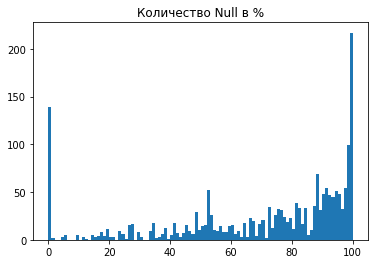

In [11]:
plt.hist(feature_null_count, bins=100)
plt.title('Количество Null в %')
plt.show()

Видно, что есть достаточно много признаков, где количество NaN больше 90%. Построим график, чтобы лучше определить порог.

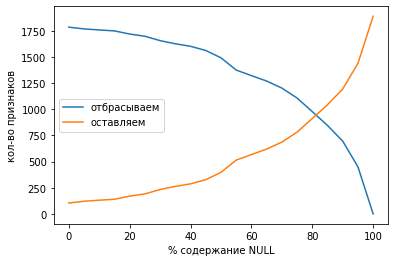

In [35]:
# порог с шагом 5 %
feature_null_count_ = []
for i in range(0, 100+1, 5):
    feature_null_count_.append(np.argwhere(feature_null_count>i).shape[0])
    
plt.plot(range(0, 100+1, 5), feature_null_count_, label='отбрасываем')
plt.plot(range(0, 100+1, 5), [1888-x for x in feature_null_count_], label='оставляем')
plt.ylabel('кол-во признаков'), plt.xlabel('% содержание NULL')
plt.legend()
plt.show()

Выберем порог в 40%.

In [36]:
features_remain = features[np.argwhere(feature_null_count<40).flatten()]

In [37]:
df_short = df[features_remain].copy()
df_short.head(3)

,incident,flg_90_12_add,APPLICATION_MONTH,Category_Feature_0,Category_Feature_1,Category_Feature_2,Category_Feature_3,Category_Feature_4,Category_Feature_5,Category_Feature_6,...,Feature_1863,Feature_1864,Feature_1865,Feature_1866,Feature_1883,Feature_1884,Feature_1885,Feature_1886,Feature_1887,PD
0,14511110,0.0,2018-10,6.0,2,25,2.0,0.0,3,1,...,5.053696,5.053696,5.053696,5.053696,0,0,0,1,20184,0.022191
1,15018800,0.0,2018-12,1.0,2,49,4.0,0.0,3,1,...,0.600000,0.600000,0.526316,0.526316,0,1,1,1,20184,0.019972
2,14499737,0.0,2018-10,6.0,2,24,1.0,0.0,3,0,...,0.790000,0.790000,0.087778,0.087778,0,1,0,1,20184,0.043884


Рассмотрим признак 'APPLICATION_MONTH'

In [38]:
df_short[~df_short['PD'].isnull()]['APPLICATION_MONTH'].value_counts()

2019-06    6732
2019-07    6687
2019-04    6686
2019-11    5906
2019-03    5679
2019-12    5427
2019-08    5349
2019-10    4843
2019-09    4692
2019-05    4669
2020-02    4521
2020-01    3965
2020-03    3592
2019-02    3554
2018-11    2999
2018-12    2254
2019-01    2230
2018-10    1832
Name: APPLICATION_MONTH, dtype: int64

In [39]:
df_short[df_short['PD'].isnull()]['APPLICATION_MONTH'].value_counts()

2020-02    374
2020-01    328
2020-03    298
Name: APPLICATION_MONTH, dtype: int64

Значения, которые нужно предсказать, взяты из трех месяцев, для которых также есть и известные значения. Также мнене удалось найти различие переменных 'flg_90_12_add' и 'PD'  по месяцам.

Поэтому этот признак также выбросим.

In [40]:
df_short = df_short.drop('APPLICATION_MONTH', axis=1)

In [41]:
# сохраним этот датасет
df_short.to_csv('df_short.csv')

--------------------------
***********
************
***********
-------------------------

In [4]:
df_short = pd.read_csv('df_short.csv', index_col='Unnamed: 0')
df_short.head(3)

,incident,flg_90_12_add,Category_Feature_0,Category_Feature_1,Category_Feature_2,Category_Feature_3,Category_Feature_4,Category_Feature_5,Category_Feature_6,Category_Feature_7,...,Feature_1863,Feature_1864,Feature_1865,Feature_1866,Feature_1883,Feature_1884,Feature_1885,Feature_1886,Feature_1887,PD
0,14511110,0.0,6.0,2,25,2.0,0.0,3,1,2.0,...,5.053696,5.053696,5.053696,5.053696,0,0,0,1,20184,0.022191
1,15018800,0.0,1.0,2,49,4.0,0.0,3,1,2.0,...,0.600000,0.600000,0.526316,0.526316,0,1,1,1,20184,0.019972
2,14499737,0.0,6.0,2,24,1.0,0.0,3,0,1.0,...,0.790000,0.790000,0.087778,0.087778,0,1,0,1,20184,0.043884


# Обработка признаков 

Добавим следующие новые признаки: количество NaN в строке, а также для категориальных переменных количество данной категории (кроме Category_Feature_8, т.к. он вообзе не очень сильно похож на категориальноую величину)

In [5]:
df_short['Category_Feature_8'].value_counts()

0.000000        10737
30000.000000     2727
40000.000000     2586
50000.000000     2501
35000.000000     2199
                ...  
48996.255450        1
19546.236667        1
69556.570000        1
10141.900000        1
83049.620000        1
Name: Category_Feature_8, Length: 24239, dtype: int64

In [6]:
df_short['NANs_cnt'] = df_short.isnull().sum(axis = 1)
for col in ['Category_Feature_'+str(i) for i in chain(range(0,8), range(9,18+1))]:
    df_short[col+'_cnt'] = df_short[col].map(df_short[col].value_counts(dropna = False))

Также вспомним, что таргетом является |PD-flg_90_12_add|. добавим эту переменную в датасет

In [7]:
df_short['diff'] = df_short.apply(lambda row: np.abs(row['PD']-row['flg_90_12_add']), axis=1)

Посмотрим на распределение таргета:

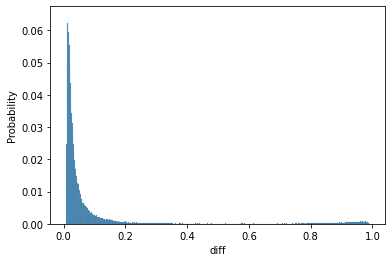

In [8]:
sns.histplot(df_short['diff'], stat='probability');

Видно, что распредление ассиметрично, а также имеет второй неваразительный пик в районе 1. Однако именно этот пик и является значимым для нас.

Чтобы исправить эту ситуацию, прологарифмируем таргет. Тогда второй пик стал более выраженным и сравним по высоте с первым пиком.

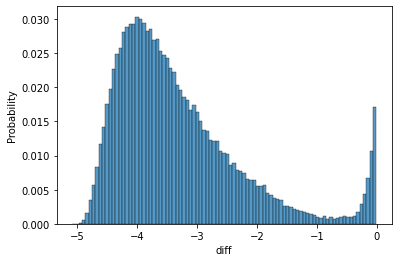

In [9]:
sns.histplot(np.log(df_short['diff']), stat='probability');

In [10]:
df_short['diff_log'] = df_short['diff'].apply(lambda x: np.log(x))
df_short.head(3)

,incident,flg_90_12_add,Category_Feature_0,Category_Feature_1,Category_Feature_2,Category_Feature_3,Category_Feature_4,Category_Feature_5,Category_Feature_6,Category_Feature_7,...,Category_Feature_11_cnt,Category_Feature_12_cnt,Category_Feature_13_cnt,Category_Feature_14_cnt,Category_Feature_15_cnt,Category_Feature_16_cnt,Category_Feature_17_cnt,Category_Feature_18_cnt,diff,diff_log
0,14511110,0.0,6.0,2,25,2.0,0.0,3,1,2.0,...,10335,64078,55978,35574,12192,2247,14703,7295,0.022191,-3.808085
1,15018800,0.0,1.0,2,49,4.0,0.0,3,1,2.0,...,71998,64078,55978,35574,42894,3726,9818,4659,0.019972,-3.913427
2,14499737,0.0,6.0,2,24,1.0,0.0,3,0,1.0,...,71998,64078,4307,4307,4307,4307,14786,4307,0.043884,-3.126204


Также заменим все пропущенные значения на -1.

In [11]:
for col in df_short.columns[2:-2]:
    df_short[col] = df_short[col].fillna(-1)
df_short

,incident,flg_90_12_add,Category_Feature_0,Category_Feature_1,Category_Feature_2,Category_Feature_3,Category_Feature_4,Category_Feature_5,Category_Feature_6,Category_Feature_7,...,Category_Feature_11_cnt,Category_Feature_12_cnt,Category_Feature_13_cnt,Category_Feature_14_cnt,Category_Feature_15_cnt,Category_Feature_16_cnt,Category_Feature_17_cnt,Category_Feature_18_cnt,diff,diff_log
0,14511110,0.0,6.0,2,25,2.0,0.0,3,1,2.0,...,10335,64078,55978,35574,12192,2247,14703,7295,0.022191,-3.808085
1,15018800,0.0,1.0,2,49,4.0,0.0,3,1,2.0,...,71998,64078,55978,35574,42894,3726,9818,4659,0.019972,-3.913427
2,14499737,0.0,6.0,2,24,1.0,0.0,3,0,1.0,...,71998,64078,4307,4307,4307,4307,14786,4307,0.043884,-3.126204
3,14953427,0.0,4.0,2,26,1.0,0.0,3,1,2.0,...,71998,64078,55978,35574,151,8470,12715,4659,0.013412,-4.311604
4,14744453,0.0,6.0,2,30,4.0,2.0,3,1,3.0,...,10335,64078,55978,35574,42894,6103,6408,4659,0.033354,-3.400582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82612,20559842,NaN,1.0,2,34,2.0,2.0,3,0,2.0,...,71998,64078,21127,1159,42894,6103,6408,7295,NaN,NaN
82613,20380255,NaN,10.0,2,66,2.0,0.0,5,1,3.0,...,71998,18255,21127,10458,9875,9881,14786,9886,NaN,NaN
82614,20348581,NaN,4.0,1,32,1.0,0.0,3,0,1.0,...,71998,64078,55978,35574,12192,3785,9228,4434,NaN,NaN
82615,21118162,NaN,5.0,2,62,5.0,0.0,6,1,1.0,...,71998,18255,21127,10458,9875,9881,14786,9886,NaN,NaN


# Модель

## 1. Построим CatBoost модель

In [12]:
df_ml_01 = df_short[~df_short['diff'].isnull()].copy()
drop_feat_list = ['incident','flg_90_12_add','PD','diff','diff_log']
feats_01 = df_ml_01.drop(drop_feat_list, axis=1).columns
target_feat_name = ['diff', 'diff_log']

train_index_01, val_index_01 = train_test_split(np.arange(df_ml_01.shape[0]), test_size=0.2, stratify = df_ml_01['flg_90_12_add'], random_state=42)

X_train_01 = df_ml_01.drop(drop_feat_list, axis=1).iloc[train_index_01].values
y_train_01 = df_ml_01[target_feat_name].iloc[train_index_01].values
X_val_01 = df_ml_01.drop(drop_feat_list, axis=1).iloc[val_index_01].values
y_val_01 = df_ml_01[target_feat_name].iloc[val_index_01].values

print('Train: ', X_train_01.shape[0], y_train_01.shape[0])
print('Val  : ', X_val_01.shape[0], y_val_01.shape[0])


Train:  65293 65293
Val  :  16324 16324


In [13]:
model_02 = CatBoostRegressor(iterations=2000,
                             verbose=False,
                             learning_rate=0.1,
                             loss_function='MAE',
                             eval_metric='MAE',
                             depth=4,
                             l2_leaf_reg=0.01,   #L2 regularization
                             min_data_in_leaf=4,
                             random_seed = 2024
                            )

In [14]:
model_02.fit(X_train_01, y_train_01[:,-1])

In [15]:
print('Train MAE: ', mean_absolute_error(y_train_01[:,-2], np.exp(model_02.predict(X_train_01))))
print('Val   MAE: ', mean_absolute_error(y_val_01[:,-2], np.exp(model_02.predict(X_val_01)))) 

Train MAE:  0.05558327652651124
Val   MAE:  0.05648612248222328


In [16]:
df_short_test = df_short[df_short['diff'].isnull()]
pred_test = np.exp(model_02.predict(df_short_test.drop(drop_feat_list, axis=1).values))
print(np.max(pred_test))
sample_submission[0] = pred_test
sample_submission.to_csv('ans_cb_02_1.csv', header=False, index=False)
sample_submission.head()

0.25800398555665904


,0
0,0.012753
1,0.030935
2,0.017231
3,0.083418
4,0.034975


**SCORE: 0.05911**

Посмотрим на веса для всех признаков.

In [81]:
feature_importance = pd.DataFrame({'feature': feats_01, 'weight': model_02.feature_importances_})
feature_importance = feature_importance.sort_values(by='weight', ascending=False, ignore_index=True)
feature_importance.to_csv('feature_importance_cb.csv')
#feature_importance = pd.read_csv('feature_importance_cb.csv')
feature_importance.head()

,feature,weight
0,Category_Feature_2,9.837595
1,Feature_795,7.382841
2,Feature_960,6.010436
3,Feature_69,5.282976
4,Feature_962,4.924803


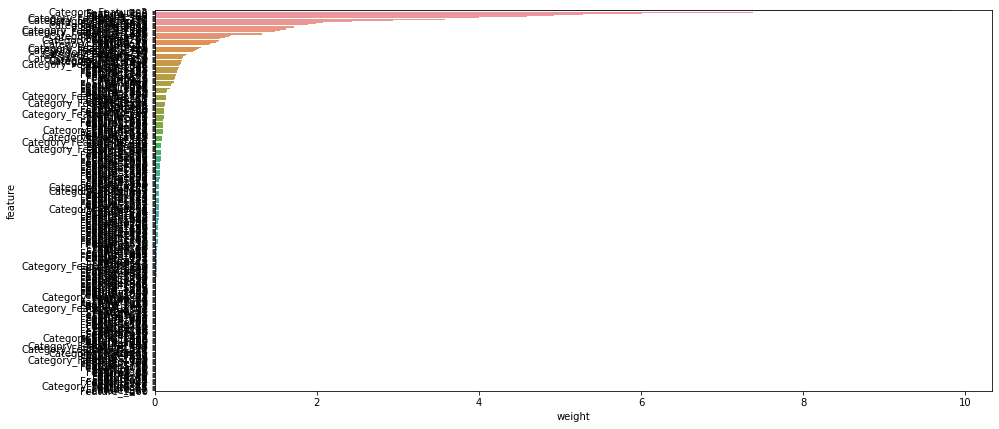

In [82]:
plt.figure(figsize=(15,7))
sns.barplot(x='weight', y='feature', data=feature_importance, orient='h');

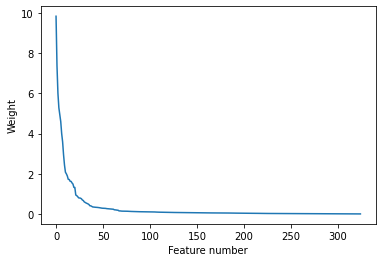

In [83]:
plt.plot(feature_importance['weight']);
plt.xlabel('Feature number'); plt.ylabel('Weight');

Многие признаки имеют веса близкие к нулю. Основываясь на графиках, оставим первые 100 признаков.

In [19]:
feature_importance.iloc[:100].to_csv('feature_importance_cb_100.csv')
significant_feats = feature_importance.iloc[:100]['feature'].values
#significant_feats = pd.read_csv('feature_importance_cb_100.csv')['feature'].values
significant_feats

array(['Category_Feature_2', 'Feature_795', 'Feature_960', 'Feature_69',
       'Feature_962', 'Category_Feature_1_cnt', 'Feature_790',
       'Category_Feature_3_cnt', 'Category_Feature_1', 'Feature_71',
       'Feature_1883', 'Category_Feature_5', 'Feature_1833',
       'Feature_1085', 'Feature_76', 'Category_Feature_15_cnt',
       'Feature_1743', 'Category_Feature_18_cnt', 'Feature_1885',
       'Feature_1886', 'Category_Feature_0', 'Feature_31', 'Feature_1765',
       'Feature_261', 'Category_Feature_15', 'Feature_95', 'Feature_22',
       'Category_Feature_18', 'Feature_57', 'Feature_949', 'Feature_6',
       'Category_Feature_0_cnt', 'Category_Feature_5_cnt', 'Feature_1760',
       'Category_Feature_10', 'Feature_797', 'Category_Feature_16',
       'Feature_77', 'Feature_3', 'Category_Feature_2_cnt',
       'Feature_1759', 'Category_Feature_8', 'Category_Feature_3',
       'Feature_1751', 'Category_Feature_16_cnt', 'Feature_1035',
       'Feature_1834', 'Feature_97', 'Feature_26

In [20]:
df_short_100 = df_short[['incident','flg_90_12_add']+list(significant_feats)+['diff','diff_log']].copy()
df_short_100.head()

,incident,flg_90_12_add,Category_Feature_2,Feature_795,Feature_960,Feature_69,Feature_962,Category_Feature_1_cnt,Feature_790,Category_Feature_3_cnt,...,Feature_672,Feature_549,Feature_1884,Feature_1084,Feature_550,Feature_649,Feature_643,Feature_18,diff,diff_log
0,14511110,0.0,25,-1.000000,1.000000,18.0,1.000000,39941,-1.000000,44156,...,2.808897,0.082487,0,1.0,0.082487,-1.000000,-1.000000,1,0.022191,-3.808085
1,15018800,0.0,49,1.000000,0.992537,133.0,0.993631,39941,1.000000,6777,...,3.552700,2.266088,1,1.0,0.088695,2.001270,1.295370,1,0.019972,-3.913427
2,14499737,0.0,24,1.020237,0.956044,49.0,0.964602,39941,1.020237,21324,...,1.144553,1.189426,1,1.0,0.041769,1.144553,0.983492,5,0.043884,-3.126204
3,14953427,0.0,26,-1.000000,-1.000000,-1.0,-1.000000,39941,-1.000000,21324,...,-1.000000,-1.000000,1,-1.0,-1.000000,-1.000000,-1.000000,0,0.013412,-4.311604
4,14744453,0.0,30,0.984897,1.000000,12.0,1.000000,39941,0.984897,6777,...,1.015135,1.183242,1,1.0,0.072245,1.015135,1.015135,4,0.033354,-3.400582


## 2. Модель со значащими 100 признаками

Посмотрим, как удаление признаков с малыми весами повлияло на модель.

In [21]:
df_ml_03 = df_short_100[~df_short_100['diff'].isnull()].copy()
drop_feat_list = ['incident','flg_90_12_add','diff','diff_log']
target_feat_name = ['diff', 'diff_log']

train_index_03, val_index_03 = train_test_split(np.arange(df_ml_03.shape[0]), test_size=0.2, stratify = df_ml_03['flg_90_12_add'], random_state=42)

X_train_03 = df_ml_03.drop(drop_feat_list, axis=1).iloc[train_index_03].values
y_train_03 = df_ml_03[target_feat_name].iloc[train_index_03].values
X_val_03 = df_ml_03.drop(drop_feat_list, axis=1).iloc[val_index_03].values
y_val_03 = df_ml_03[target_feat_name].iloc[val_index_03].values

print('Train: ', X_train_03.shape[0], y_train_03.shape[0])
print('Val  : ', X_val_03.shape[0], y_val_03.shape[0])


Train:  65293 65293
Val  :  16324 16324


In [88]:
model_03 = CatBoostRegressor(iterations=2000,
                             verbose=False,
                             learning_rate=0.1,
                             loss_function='MAE',
                             eval_metric='MAE',
                             depth=4,
                             l2_leaf_reg=0.01,
                             min_data_in_leaf=4,
                             random_seed = 2024
                            )

In [89]:
model_03.fit(X_train_03, y_train_03[:,-1])

In [90]:
print('Train MAE: ', mean_absolute_error(y_train_03[:,-2], np.exp(model_03.predict(X_train_03))))
print('Val   MAE:', mean_absolute_error(y_val_03[:,-2], np.exp(model_03.predict(X_val_03))))

Train MAE:  0.05560688296617053
Val   MAE: 0.056431632213792736


In [91]:
df_short_test_03 = df_short_100[df_short_100['diff'].isnull()].drop(drop_feat_list, axis=1)
pred_test_03 = np.exp(model_03.predict(df_short_test_03.values))
print(np.max(pred_test_03))
pred_test_03[pred_test_03>1.]=1.
sample_submission[0] = pred_test_03
sample_submission.to_csv('ans_cb_03.csv', header=False, index=False)
sample_submission.head()

0.2821057410026358


,0
0,0.012006
1,0.035242
2,0.017511
3,0.095542
4,0.035823


**SCORE: 0.05893** (скор ухудшился незначительно)

## 2.1 Изменили loss с MAE на RMSE

Попоробуем в качестве loss функции взять RMSE, а не MAE.

In [22]:
model_04 = CatBoostRegressor(iterations=2000,
                             verbose=False,
                             learning_rate=0.1,
                             loss_function='RMSE',
                             eval_metric='MAE',
                             depth=4,
                             l2_leaf_reg=0.01,
                             min_data_in_leaf=4,
                             random_seed = 2024
                            )

In [23]:
model_04.fit(X_train_03, y_train_03[:,-1])

In [98]:
print('Train MAE: ', mean_absolute_error(y_train_03[:,-2], np.exp(model_04.predict(X_train_03))))
print('Val   MAE:', mean_absolute_error(y_val_03[:,-2], np.exp(model_04.predict(X_val_03))))

Train MAE:  0.05398872410668391
Val   MAE: 0.057943293005780355


In [99]:
pred_test_04 = np.exp(model_04.predict(df_short_test_03.values))
print(np.max(pred_test_04))
pred_test_04[pred_test_04>1.]=1.
sample_submission[0] = pred_test_04
sample_submission.to_csv('ans_cb_04.csv', header=False, index=False)
sample_submission.head()

0.3271904845481116


,0
0,0.011804
1,0.039110
2,0.022752
3,0.124827
4,0.042880


**SCORE: 0.05891** (скор увеличился незначительно)

## 3. Преобзразование Бокса-Кокса над таргетом

Попробуем еще одно преобразование таргета - преобразование Бокса-Кокса.

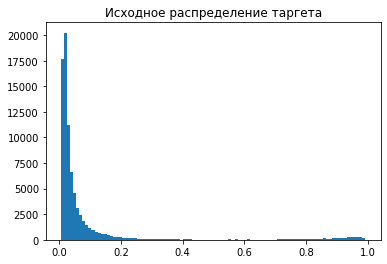

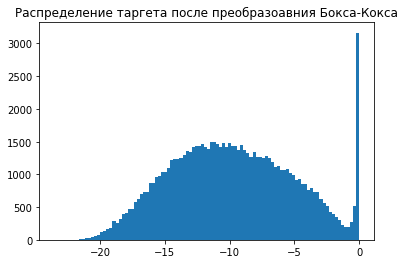

In [24]:
boxcox_lambda = -0.5
plt.hist(df_short_100['diff'], bins=100);
plt.title('Исходное распределение таргета');
plt.show()
plt.hist(boxcox(df_short_100['diff'], boxcox_lambda), bins=100);
plt.title('Распределение таргета после преобразоавния Бокса-Кокса');

In [25]:
df_short_100['diff_boxcox'] = boxcox(df_short_100['diff'], boxcox_lambda)
df_short_100.head(3)

,incident,flg_90_12_add,Category_Feature_2,Feature_795,Feature_960,Feature_69,Feature_962,Category_Feature_1_cnt,Feature_790,Category_Feature_3_cnt,...,Feature_549,Feature_1884,Feature_1084,Feature_550,Feature_649,Feature_643,Feature_18,diff,diff_log,diff_boxcox
0,14511110,0.0,25,-1.000000,1.000000,18.0,1.000000,39941,-1.000000,44156,...,0.082487,0,1.0,0.082487,-1.000000,-1.000000,1,0.022191,-3.808085,-11.425954
1,15018800,0.0,49,1.000000,0.992537,133.0,0.993631,39941,1.000000,6777,...,2.266088,1,1.0,0.088695,2.001270,1.295370,1,0.019972,-3.913427,-12.152065
2,14499737,0.0,24,1.020237,0.956044,49.0,0.964602,39941,1.020237,21324,...,1.189426,1,1.0,0.041769,1.144553,0.983492,5,0.043884,-3.126204,-7.547213


In [26]:
df_ml_05 = df_short_100[~df_short_100['diff'].isnull()].copy()
drop_feat_list_05 = ['incident','flg_90_12_add','diff','diff_log','diff_boxcox']
target_feat_name_05 = ['diff', 'diff_boxcox']

train_index_05, val_index_05 = train_test_split(np.arange(df_ml_05.shape[0]), test_size=0.2, stratify = df_ml_05['flg_90_12_add'], random_state=42)

X_train_05 = df_ml_05.drop(drop_feat_list_05, axis=1).iloc[train_index_05].values
y_train_05 = df_ml_05[target_feat_name_05].iloc[train_index_05].values
X_val_05 = df_ml_05.drop(drop_feat_list_05, axis=1).iloc[val_index_05].values
y_val_05 = df_ml_05[target_feat_name_05].iloc[val_index_05].values

print('Train: ', X_train_05.shape[0], y_train_05.shape[0])
print('Val  : ', X_val_05.shape[0], y_val_05.shape[0])


Train:  65293 65293
Val  :  16324 16324


In [27]:
model_05 = CatBoostRegressor(iterations=2000,
                             verbose=0,
                             learning_rate=0.1,
                             loss_function='RMSE',
                             eval_metric='MAE',
                             depth=4,
                             l2_leaf_reg=0.01,
                             min_data_in_leaf=4,
                             random_seed = 2024
                            )

In [28]:
model_05.fit(X_train_05, y_train_05[:,-1])

In [29]:
pred_train_05 = model_05.predict(X_train_05)
pred_val_05 = model_05.predict(X_val_05)

Для корректного обратного преобразования предсказываемые величины должны быть меньше нуля. Однако это не так. 
Стоит отметить, что вообще допустимые значения могут быть меньше 2 (1/lambda=1/0.5=2) (inv_boxcox(2, lambda)=inf). Однако на промежутке [0, 2] возвращаемые значения будут очень болшими. При значениях больше 2 обратная функция будет выдавать NaN.

Адекватные значения после обратного преобразования [0,1] будут при значениях меньше нуля.

Возможно имеет смысл обозначить данные записи как выбросы и исключить из обучающей выборки.

Но пока посмотрим на скор, если искусственно ограничить значения.

In [30]:
pred_train_05[pred_train_05>=0.1]

array([0.68436754, 0.78107448, 1.5907975 , 0.59367393, 0.10806047,
       0.24470377, 0.62446224, 0.25488865, 0.67220746, 0.33264765,
       0.58430982, 0.31096414, 0.41566886, 0.14802245, 0.67273547,
       0.52841124, 0.12697958, 0.17419046, 0.45907137, 1.63786252,
       0.29712204, 0.15336483, 0.41692419, 0.70816823, 0.43511738,
       0.54267417, 0.39302981, 0.17149922, 0.72141847, 0.3774309 ,
       0.97510675, 0.16961792, 0.27307478, 0.9394411 , 0.28694298,
       0.20697316, 0.75189996, 1.09750646, 0.36701468, 0.65262023,
       0.50189247, 0.59344876, 0.44192793, 0.5285722 , 0.18414403,
       0.37127996, 1.58284462, 0.57121776, 0.10642495, 0.34380357,
       0.2294258 , 0.188717  , 1.45227143, 0.2025961 , 0.42195788,
       1.23103979, 0.41607292, 0.45011191, 1.01954878, 0.20627624,
       0.867809  , 1.53105827, 0.74064499, 0.979328  , 0.30005109,
       0.53014201, 0.42661531, 0.52435351, 0.79210929, 1.29491999,
       0.43865608, 0.96334788, 0.72228223, 0.45778347, 0.41485

In [31]:
inv_boxcox(2, boxcox_lambda)

inf

In [32]:
pred_train_05[pred_train_05>0] = 0.
pred_val_05[pred_val_05>0] = 0.

In [33]:
print(mean_absolute_error(y_train_05[:,-2], inv_boxcox(pred_train_05, boxcox_lambda)))
print(mean_absolute_error(y_val_05[:,-2], inv_boxcox(pred_val_05, boxcox_lambda)))

0.056053883803240986
0.05758735987920733


In [34]:
df_short_test_05 = df_short_100[df_short_100['diff'].isnull()].drop(drop_feat_list_05, axis=1)
pred_test_05 = model_05.predict(df_short_test_05.values)
print(np.max(pred_test_05))
pred_test_05[pred_test_05>0] = 0.
print(np.max(pred_test_05))
sample_submission[0] = inv_boxcox(pred_test_05, boxcox_lambda)
sample_submission.to_csv('ans_cb_05.csv', header=False, index=False)
sample_submission.head()

-0.6741881835894983
-0.6741881835894983


,0
0,0.012601
1,0.033917
2,0.019131
3,0.109721
4,0.034166


**SCORE: 0.05886**

Скор улучшился. Попробуем удалить 'выбросы', о которых говорилось выше.

Для выявления записей, которые будем удалять из обучающей выборки, обучим модель на всей этой выборке.

In [35]:
df_ml_06 = df_short_100[~df_short_100['diff'].isnull()].copy()
drop_feat_list_06 = ['incident','flg_90_12_add','diff','diff_log','diff_boxcox']
target_feat_name_06 = ['diff', 'diff_boxcox']

X_06 = df_ml_06.drop(drop_feat_list_06, axis=1).values
y_06 = df_ml_06[target_feat_name_06].values

print('Train: ', X_06.shape[0], y_06.shape[0])


Train:  81617 81617


In [36]:
model_06 = CatBoostRegressor(iterations=2000,
                             verbose=0,
                             learning_rate=0.1,
                             loss_function='RMSE',
                             eval_metric='MAE',
                             depth=4,
                             l2_leaf_reg=0.01,
                             min_data_in_leaf=4,
                             random_seed = 2024
                            )

In [37]:
model_06.fit(X_06, y_06[:,-1])

In [38]:
pred_train_06 = model_06.predict(X_06)

Список индексов 'incident' удаляемых записей.

In [39]:
boxcox_index_drop = df_ml_06.iloc[np.argwhere(pred_train_06>0).flatten()]['incident'].values
boxcox_index_drop

array([14888768, 14889119, 15067717, 17722398, 16229053, 16590678,
       18440594, 18019937, 16769837, 17717120, 16830493, 16828155,
       16879109, 19212452, 19410030, 17326797, 17412835, 17565278,
       17465997, 17619884, 16988971, 16669300, 15342172, 16564176,
       16722163, 16464829, 16554188, 16601895, 16692532, 16412657,
       16330187, 15979257, 16145714, 16060963, 15952655, 15903063,
       15840444, 18245471, 18154378, 18630124, 18352348, 18519797,
       18884802, 19119328, 18787871, 19098345, 18910282, 19908937,
       20163309, 15111155, 15110740, 20078985, 15484593, 15650939,
       15589209, 15694395, 16691460, 18826025, 18522623, 15843103,
       16510828, 20140464, 16870715, 16761025, 17562810, 19505608,
       17349776, 16834663, 16882880, 15879868, 15767895, 17145296,
       19976742, 16419051, 16448605, 17658437, 17296926, 15628167,
       15204369, 15394394, 16234508, 18328365, 18549891, 17521622,
       19397570, 17261439, 17291136, 19575522, 18600354, 19191

In [40]:
df_ml_07 = df_ml_06[~df_ml_06['incident'].isin(boxcox_index_drop)]
df_ml_07

,incident,flg_90_12_add,Category_Feature_2,Feature_795,Feature_960,Feature_69,Feature_962,Category_Feature_1_cnt,Feature_790,Category_Feature_3_cnt,...,Feature_549,Feature_1884,Feature_1084,Feature_550,Feature_649,Feature_643,Feature_18,diff,diff_log,diff_boxcox
0,14511110,0.0,25,-1.000000,1.000000,18.0,1.000000,39941,-1.000000,44156,...,0.082487,0,1.000000,0.082487,-1.000000,-1.000000,1,0.022191,-3.808085,-11.425954
1,15018800,0.0,49,1.000000,0.992537,133.0,0.993631,39941,1.000000,6777,...,2.266088,1,1.000000,0.088695,2.001270,1.295370,1,0.019972,-3.913427,-12.152065
2,14499737,0.0,24,1.020237,0.956044,49.0,0.964602,39941,1.020237,21324,...,1.189426,1,1.000000,0.041769,1.144553,0.983492,5,0.043884,-3.126204,-7.547213
3,14953427,0.0,26,-1.000000,-1.000000,-1.0,-1.000000,39941,-1.000000,21324,...,-1.000000,1,-1.000000,-1.000000,-1.000000,-1.000000,0,0.013412,-4.311604,-15.269622
4,14744453,0.0,30,0.984897,1.000000,12.0,1.000000,39941,0.984897,6777,...,1.183242,1,1.000000,0.072245,1.015135,1.015135,4,0.033354,-3.400582,-8.951078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81612,20998757,0.0,56,0.991550,0.985294,50.0,0.988439,39941,0.991550,44156,...,1.273057,0,1.000000,0.113333,1.246702,1.033939,4,0.037867,-3.273686,-8.277838
81613,20999207,0.0,29,1.000000,0.992126,89.0,0.993377,39941,1.000000,44156,...,2.619534,0,1.000000,0.090994,1.280000,1.056429,2,0.014266,-4.249905,-14.745003
81614,20999293,0.0,54,0.701563,0.756906,174.0,0.828859,42676,0.701563,44156,...,1.278203,0,0.893908,0.068258,1.295484,0.993453,3,0.103010,-2.272928,-4.231464
81615,20999311,0.0,55,-1.000000,1.000000,-1.0,1.000000,39941,-1.000000,21324,...,0.650611,1,1.000000,0.650611,-1.000000,-1.000000,0,0.019119,-3.957089,-12.464417


## 3.1 boxcox(target) на 'очищенном' датасете

Теперь обучим модель на 'очищенном' датасете.

In [41]:
drop_feat_list_07 = ['incident','flg_90_12_add','diff','diff_log','diff_boxcox']
target_feat_name_07 = ['diff', 'diff_boxcox']

train_index_07, val_index_07 = train_test_split(np.arange(df_ml_07.shape[0]), test_size=0.2, stratify = df_ml_07['flg_90_12_add'], random_state=42)

X_train_07 = df_ml_07.drop(drop_feat_list_07, axis=1).iloc[train_index_07].values
y_train_07 = df_ml_07[target_feat_name_07].iloc[train_index_07].values
X_val_07 = df_ml_07.drop(drop_feat_list_07, axis=1).iloc[val_index_07].values
y_val_07 = df_ml_07[target_feat_name_07].iloc[val_index_07].values

print('Train: ', X_train_07.shape[0], y_train_07.shape[0])
print('Val  : ', X_val_07.shape[0], y_val_07.shape[0])


Train:  65212 65212
Val  :  16304 16304


In [113]:
model_07 = CatBoostRegressor(iterations=2000,
                             verbose=0,
                             learning_rate=0.1,
                             loss_function='RMSE',
                             eval_metric='MAE',
                             depth=4,
                             l2_leaf_reg=0.01,
                             min_data_in_leaf=4,
                             random_seed = 2024
                            )

In [114]:
model_07.fit(X_train_07, y_train_07[:,-1])

В данном случае также есть значения больше нуля, но их уже меньше. Ограничим их искусственно и посмотрим, что получилось.

In [115]:
pred_train_07 = model_07.predict(X_train_07)
pred_val_07 = model_07.predict(X_val_07)
pred_train_07[pred_train_07>0] = 0
pred_val_07[pred_val_07>0] = 0

In [116]:
print('Train MAE: ', mean_absolute_error(y_train_07[:,-2], inv_boxcox(pred_train_07, boxcox_lambda)))
print('Val   MAE: ', mean_absolute_error(y_val_07[:,-2], inv_boxcox(pred_val_07, boxcox_lambda)))

Train MAE:  0.05547890068951569
Val   MAE:  0.05810182697882376


In [117]:
pred_test_07 = model_07.predict(df_short_test_05.values)
print(np.max(pred_test_07))
pred_test_07[pred_test_07>0] = 0.
print(np.max(pred_test_07))
sample_submission[0] = inv_boxcox(pred_test_07, boxcox_lambda)
sample_submission.to_csv('ans_cb_07.csv', header=False, index=False)
sample_submission.head()

0.16873145194592176
0.0


,0
0,0.013006
1,0.032705
2,0.019639
3,0.114942
4,0.034382


**SCORE: 0.05887**

Метрика почти не изменилась, однако разница MAE на тренировочной и валидационной выборке увеличилась. Попробуем усилисть регуляризацию.

## 3.2 boxcox(target) на 'очищенном' датасете с усиленной регуляризацией

In [118]:
model_10 = CatBoostRegressor(iterations=2000,
                             verbose=0,
                             learning_rate=0.1,
                             loss_function='RMSE',
                             eval_metric='MAE',
                             depth=4,
                             l2_leaf_reg=25,
                             min_data_in_leaf=4,
                             random_seed = 2024
                            )

In [119]:
model_10.fit(X_train_07, y_train_07[:,-1])

In [120]:
pred_train_10 = model_10.predict(X_train_07)
pred_val_10 = model_10.predict(X_val_07)
pred_train_10[pred_train_10>0] = 0
pred_val_10[pred_val_10>0] = 0

In [121]:
print('Train MAE: ', mean_absolute_error(y_train_07[:,-2], inv_boxcox(pred_train_10, boxcox_lambda)))
print('Val   MAE: ', mean_absolute_error(y_val_07[:,-2], inv_boxcox(pred_val_10, boxcox_lambda)))

Train MAE:  0.056301972942231916
Val   MAE:  0.05793688455506815


In [122]:
pred_test_10 = model_10.predict(df_short_test_05.values)
print(np.max(pred_test_10))
pred_test_07[pred_test_10>0] = 0.
print(np.max(pred_test_10))
sample_submission[0] = inv_boxcox(pred_test_10, boxcox_lambda)
sample_submission.to_csv('ans_cb_10.csv', header=False, index=False)
sample_submission.head()

0.18551004463898657
0.18551004463898657


,0
0,0.012889
1,0.031623
2,0.019087
3,0.115027
4,0.033749


**SCORE: 0.05844**

Значение l2_leaf_reg=25 было выбрано подбором.
- (10) SCORE: 0.05888 (train: 0.055915; val: 0.057883)
- (20) SCORE: 0.05858 (train: 0.056075; val: 0.057966)
- (25) SCORE: 0.05844 (train: 0.056302; val: 0.057937)
- (30) SCORE: 0.05879 (train: 0.056377; val: 0.0577884)

## 3.3 log(target) на 'очищенном' датасете

Посмотрим, что будет, если на 'очищенном' датасете обучить модель, для которой таргет будет прологарфимрован.

In [47]:
drop_feat_list_08 = ['incident','flg_90_12_add','diff','diff_log','diff_boxcox']
target_feat_name_08 = ['diff', 'diff_log']

train_index_08, val_index_08 = train_test_split(np.arange(df_ml_07.shape[0]), test_size=0.2, stratify = df_ml_07['flg_90_12_add'], random_state=42)

X_train_08 = df_ml_07.drop(drop_feat_list_08, axis=1).iloc[train_index_08].values
y_train_08 = df_ml_07[target_feat_name_08].iloc[train_index_08].values
X_val_08 = df_ml_07.drop(drop_feat_list_08, axis=1).iloc[val_index_08].values
y_val_08 = df_ml_07[target_feat_name_08].iloc[val_index_08].values

print('Train: ', X_train_08.shape[0], y_train_08.shape[0])
print('Val  : ', X_val_08.shape[0], y_val_08.shape[0])


Train:  65212 65212
Val  :  16304 16304


In [48]:
model_08 = CatBoostRegressor(iterations=2000,
                             verbose=0,
                             learning_rate=0.1,
                             loss_function='RMSE',
                             eval_metric='MAE',
                             depth=4,
                             l2_leaf_reg=0.01,
                             min_data_in_leaf=4,
                             random_seed = 2024
                            )

In [49]:
model_08.fit(X_train_08, y_train_08[:,-1])

In [50]:
print('Train MAE: ', mean_absolute_error(y_train_08[:,-2], np.exp(model_08.predict(X_train_08))))
print('Val   MAE: ', mean_absolute_error(y_val_08[:,-2], np.exp(model_08.predict(X_val_08))))

Train MAE:  0.05362291278207441
Val   MAE:  0.05807732580237501


In [51]:
pred_test_08 = model_08.predict(df_short_test_05.values)
print(np.max(np.exp(pred_test_08)))
sample_submission[0] = np.exp(pred_test_08)
sample_submission.to_csv('ans_cb_08.csv', header=False, index=False)
sample_submission.head()

0.4071485499633391


,0
0,0.011927
1,0.032796
2,0.020397
3,0.132897
4,0.039685


**SCORE: 0.05891**

В данном случае опять можно говорить о некотором переобучении модели, поэтому усилим регулярзацию.

## 3.4 log(target) на 'очищенном' датасете с усиленной регуляризацией

In [74]:
model_09 = CatBoostRegressor(iterations=2000,
                             verbose=0,
                             learning_rate=0.1,
                             loss_function='RMSE',
                             eval_metric='MAE',
                             depth=4,
                             l2_leaf_reg=30,
                             min_data_in_leaf=4,
                             random_seed = 2024
                            )

In [75]:
model_09.fit(X_train_08, y_train_08[:,-1])

In [76]:
print('Train MAE: ', mean_absolute_error(y_train_08[:,-2], np.exp(model_09.predict(X_train_08))))
print('Val   MAE: ', mean_absolute_error(y_val_08[:,-2], np.exp(model_09.predict(X_val_08))))

Train MAE:  0.05577987242572401
Val   MAE:  0.05762641172929244


In [77]:
pred_test_09 = model_09.predict(df_short_test_05.values)
print(np.max(np.exp(pred_test_09)))
sample_submission[0] = np.exp(pred_test_09)
sample_submission.to_csv('ans_cb_09.csv', header=False, index=False)
sample_submission.head()

0.46356864563164424


,0
0,0.012105
1,0.037495
2,0.020808
3,0.133348
4,0.040995


Путем перебора оптимальным значением оказалось l2_leaf_reg=30 

**SCORE: 0.05875**

SCORE: 0.05896 (l2_leaf_reg=40)
SCORE: 0.05886 (l2_leaf_reg=35)

**Краткое описание:**


№    |model |score
-----|-----|----- 
1|просто CatBoost для выявления незначащих признаков|0.05911
2|в датасете оставили только значащие 100 признаков|0.05893
2.1|изменение loss функции MAE->RMSE|0.05891
3|преобразование Бокса-Кокса над таргетом boxcox(target)|0.05886
3.1|датасет с некоторыми удаленными записями с boxcox(target)|0.05887
3.2|модель 3.2 с усиленной регуляризацией|0.05844
3.3|датасет с некоторыми удаленными записями с log(target)|0.05891
3.4|модель 3.2 с усиленной регуляризацией|0.05875

Наилучший скор на тестово выборке показала модель с преобразованием Бокса-Кокса над таргетом, обученная на 'очищенном' датасете